# 1. Objet

Ce script retraite les données brutes enregistrées par le RawDataProcessor afin de :
- contrôler la conformité à certaines règles de gestion métier
- nettoyer les avoirs lorsque c'est possible
- agréger les informations à une maille commande
- calculer le canal majoritaire en poids
- effectuer d'autres aggrégations si nécessaire (ex : types de tarif...)

# 2. Imports et setup technique

In [1]:
from pathlib import Path
import sys
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
project_root = str(Path(sys.path[0]).parents[0].absolute())
project_root
if project_root not in sys.path:
    sys.path.append(project_root)
import multiprocessing as mp
    
from scripts.utils import process_df  # traitement des avoirs
    
data_path = Path('..') / 'data'
persist_path = Path('..') / 'persist'
from IPython.display import display, HTML
display(HTML("<style>.container { width:90%; }</style>"))

from dask.distributed import LocalCluster, Client
import dask.dataframe as dd
client = Client(
    n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    dashboard_address=':35000'
) # n_workers=1, threads_per_worker=4, processes=False, memory_limit='2GB'
client

Client Scheduler: tcp://127.0.0.1:34540 Dashboard: http://127.0.0.1:35000/status,Cluster Workers: 7 Cores: 7 Memory: 33.56 GB


In [2]:
orgacom_list = [
    '1ALO',
    '1BFC',
    '1CAP',
    '1CTR',
    '1EXP',
    '1LRO',
    '1LXF',
    '1NCH',
    '1OUE',
    '1PAC',
#     '1PLU', 
    '1PNO',
    '1PSU',
    '1RAA',
    '1SOU',
    '2BRE',
    '2CAE',
    '2CTR',
    '2EST',
    '2IDF',
#     '2IFC', Cash Européenne Food ?
    '2MPY',
    '2NOR',
    '2RAA',
    '2SES',
    '2SOU',
]

# Chargement des données brutes

In [3]:
%%time
with LocalCluster(
    n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    dashboard_address=':36000',
#     memory_limit='2GB',
#     ip='tcp://localhost:9895',
) as cluster, Client(cluster) as client_:
    raw_data = dd.read_parquet(persist_path / 'raw_data.parquet')
    print(f'Il y a {len(raw_data)} lignes dans le dataset')

Il y a 229941217 lignes dans le dataset
CPU times: user 1.29 s, sys: 243 ms, total: 1.53 s
Wall time: 4.9 s


In [4]:
# timed : 6,45s

# %%time
# with LocalCluster(
#     n_workers=int(0.9 * mp.cpu_count()),
#     processes=False,
#     threads_per_worker=1,
#     dashboard_address=':36000',
# #     memory_limit='2GB',
# #     ip='tcp://localhost:9895',
# ) as cluster, Client(cluster) as client_:
#     raw_data = dd.read_parquet(persist_path / 'raw_data.parquet')
#     print(f'Il y a {len(raw_data)} lignes dans le dataset')

Il est nécessaire de recharger les catégories à la lecture du fichier parquet.
https://docs.dask.org/en/latest/dataframe-categoricals.html

In [5]:
for field in raw_data.dtypes.loc[lambda x: x == 'category'].index:
    raw_data[field] = raw_data[field].cat.set_categories(raw_data[field].head(1).cat.categories)

# Contrôle des données

On définit les fonctions qui vont permettre d'effectuer les contrôles.

### Contrôle des types de documents

In [6]:
valid_doctypes = ['ZC01', 'ZC02', 'ZC10'] # documents de type "commandes"
invalid_doctypes = ['ZR01', 'ZR02', 'ZA01', 'ZA02', 'ZA03', 'ZA04', 'ZC20']  # autres types de documents
doctypes = valid_doctypes + invalid_doctypes   

On s'assure qu'on n'a pas de type de document non prévu.

In [7]:
def ctrle_doctypes(data):
    if len(data.loc[~data.doctype.isin(doctypes)]) > 0:
        print(f'Unexpected doctypes have been encountered: '
              f'{data.loc[~data.doctype.isin(doctypes), "doctype"].value_counts().compute()}!')

In [8]:
%%time
with LocalCluster(
    n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    dashboard_address=':36000',
#     memory_limit='2GB',
#     ip='tcp://localhost:9895',
) as cluster, Client(cluster) as client_:    
    ctrle_doctypes(raw_data)

Unexpected doctypes have been encountered: #      959834
ZB1       874
ZB5       435
Name: doctype, dtype: int64!
CPU times: user 14 s, sys: 1.81 s, total: 15.8 s
Wall time: 2min


In [9]:
# timed to 8min 11s => mainly python code, should use processes.

# %%time
# with LocalCluster(
#     n_workers=int(0.9 * mp.cpu_count()),
#     processes=False,
#     threads_per_worker=1,
#     dashboard_address=':36000',
# #     memory_limit='2GB',
# #     ip='tcp://localhost:9895',
# ) as cluster, Client(cluster) as client_:    
#     ctrle_doctypes(raw_data)

### Contrôle des CA bruts non nuls alors que le poids est nul

D'un point de vue métier, il n'est pas possible qu'une ligne de **commande** (= valid_doctype) avec un poids nul ait un CA brut, sauf pour certains articles de service

Je veux : un rapport qui me sort, par succursale, les produits qui ont des lignes avec du revenue mais pas de poids, en comptant le nombre de lignes.

In [10]:
def ctrle_no_weight_revenue(data, order_doctypes=valid_doctypes):
    return(
        data.loc[
            data.doctype.isin(order_doctypes) &
            (data.weight == 0) &
            (data.brutrevenue != 0)
        ]
        .compute()
        .groupby(['orgacom', 'material'], observed=True)
        .size()
        .to_frame()
    )

In [11]:
%%time
with LocalCluster(
    n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    dashboard_address=':36000',
#     memory_limit='2GB',
#     ip='tcp://localhost:9895',
) as cluster, Client(cluster) as client_:
    result = ctrle_no_weight_revenue(raw_data)

CPU times: user 9.19 s, sys: 1.12 s, total: 10.3 s
Wall time: 1min 1s


In [12]:
# timed : 4min 14s

# %%time
# with LocalCluster(
#     n_workers=int(0.9 * mp.cpu_count()),
#     processes=False,
#     threads_per_worker=1,
#     dashboard_address=':36000',
# #     memory_limit='2GB',
# #     ip='tcp://localhost:9895',
# ) as cluster, Client(cluster) as client_:
#     result = ctrle_no_weight_revenue(raw_data)

In [13]:
with pd.option_context('display.max_columns', None):
    display(result.unstack('orgacom', fill_value=0).sort_index(axis=1).style.bar(align='mid', axis=None))

L'essentiel des articles concernés sont des articles de service (forfaits livraison). Il faudrait regarder ce qui s'est passé sur le 156486, il remonte régulièrement côté ES.

### Contrôle des origines de commande

In [14]:
# def ctrle_origin(data, valid_origins=valid_origins):
#     report = data.loc[
#         ~data.origin.isin(valid_origins) &
#         (data.brutrevenue != 0) &
#         data.doctype.isin(valid_doctypes)
#     ].value_counts('origin').rename('counts').to_frame()
#     report['percentage'] = report['counts'] / sum(
#         (data.brutrevenue != 0) &
#         data.doctype.isin(valid_doctypes)
#     )
#     return(report.loc[report['counts'] > 0])

In [15]:
valid_origins = ['TV', 'VR', 'WEB', 'EDI']

def ctrle_origin(data, valid_origins=valid_origins):
    sizes = (
        data.loc[
            (data.brutrevenue != 0) &
            data.doctype.isin(valid_doctypes)
        ].groupby(['orgacom'], observed=True).size()
        .compute()
    ).rename('baseline')
    
    invalid_origins = (
        data.loc[
            (data.brutrevenue != 0) &
            data.doctype.isin(valid_doctypes) &
            ~data.origin.isin(valid_origins)
        ].groupby(['orgacom', 'origin'], observed=True).size()
        .compute()    
    ).rename('invalid').to_frame()
    invalid_origins = invalid_origins.reset_index().merge(sizes.reset_index(), on='orgacom', how='left')
    invalid_origins['percentage'] = invalid_origins['invalid'] / invalid_origins['baseline']
    return(invalid_origins)

In [16]:
%%time
with LocalCluster(
    n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    dashboard_address=':36000',
#     memory_limit='2GB',
#     ip='tcp://localhost:9895',
) as cluster, Client(cluster) as client:
    display(ctrle_origin(raw_data).sort_values(['orgacom', 'origin']).style.format({'percentage': lambda x: f'{x:.2%}'}).bar(subset=['percentage'], align='mid', ))

,orgacom,origin,invalid,baseline,percentage
9,1ALO,#,21339,14019888,0.15%
42,1ALO,TELE,5,14019888,0.00%
32,1ALO,DFUE,3,14019888,0.00%
13,1BFC,#,4151,7625418,0.05%
0,1CAP,#,2320,301484,0.77%
12,1CAP,SCHR,98,301484,0.03%
18,1CTR,#,5598,7428760,0.08%
35,1CTR,DFUE,39,7428760,0.00%
27,1EXP,#,124,52145,0.24%
23,1LRO,#,4549,7062511,0.06%


CPU times: user 15.6 s, sys: 1.86 s, total: 17.4 s
Wall time: 2min 9s


In [17]:
# timed: 8min 59s...

# %%time
# with LocalCluster(
#     n_workers=int(0.9 * mp.cpu_count()),
#     processes=False,
#     threads_per_worker=1,
#     dashboard_address=':36000',
# #     memory_limit='2GB',
# #     ip='tcp://localhost:9895',
# ) as cluster, Client(cluster) as client:
#     display(ctrle_origin(raw_data).sort_values(['orgacom', 'origin']).style.format({'percentage': lambda x: f'{x:.2%}'}).bar(subset=['percentage'], align='mid', ))

### Retraitement des avoirs

In [18]:
# from scripts import utils
# reload(utils)

In [19]:
%%time

with LocalCluster(
    n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    dashboard_address=':36000',
) as cluster, Client(cluster) as client:
    processed_ddf = raw_data.map_partitions(
        process_df,
        meta=raw_data,
    )

CPU times: user 203 ms, sys: 182 ms, total: 385 ms
Wall time: 2 s


In [20]:
%%time

with LocalCluster(
    n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    dashboard_address=':36000',
) as cluster, Client(cluster) as client:
    processed_1ALO = (processed_ddf.loc[lambda x: x.orgacom == '1ALO'].compute())
    raw_1ALO = raw_data.loc[raw_data.orgacom == '1ALO'].compute()

CPU times: user 1min 31s, sys: 24.2 s, total: 1min 55s
Wall time: 9min 2s


Text(0.5, 0.98, 'Illustration du nettoyage des avoirs - Succursale 1ALO')

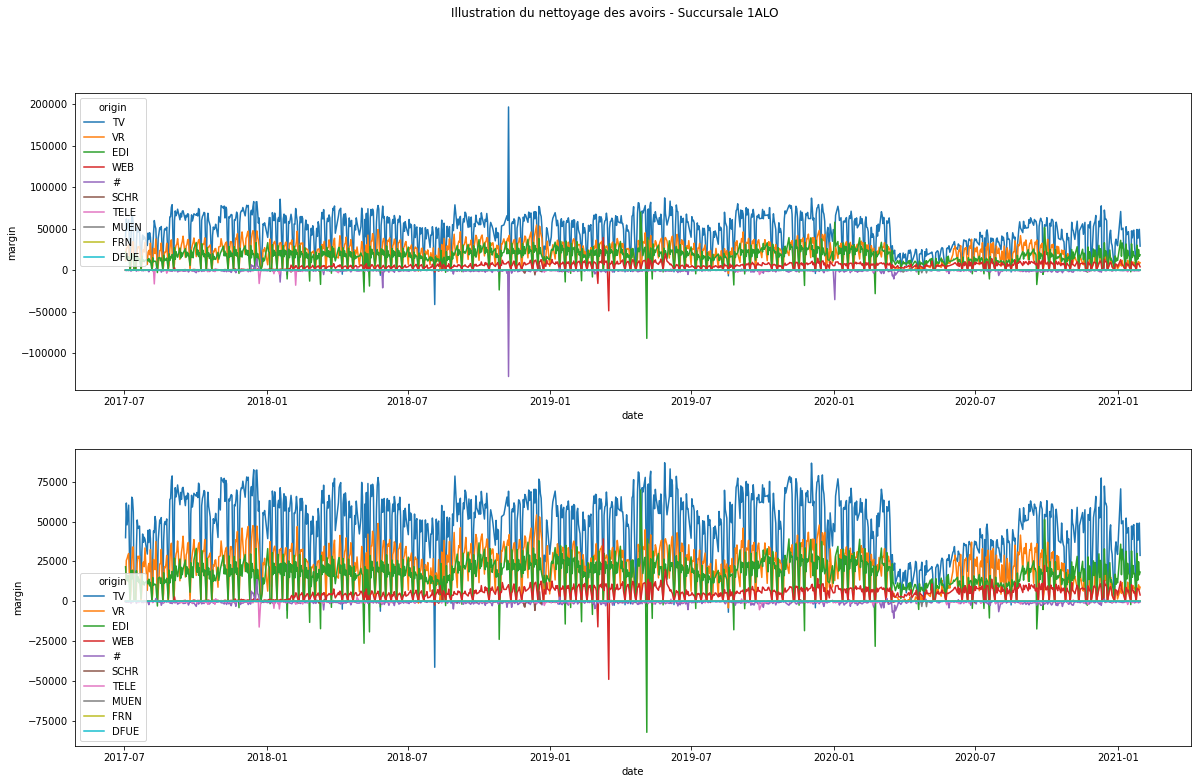

In [21]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 12))
sns.lineplot(
    data=raw_1ALO.groupby(['date', 'origin'])[['weight', 'brutrevenue', 'margin']].sum(),
    x='date',
    y='margin',
    hue='origin',
    ax=axs[0],
)
sns.lineplot(
    data=processed_1ALO.groupby(['date', 'origin'])[['weight', 'brutrevenue', 'margin']].sum(),
    x='date',
    y='margin',
    hue='origin',
    ax=axs[1],
)
fig.suptitle('Illustration du nettoyage des avoirs - Succursale 1ALO')

In [22]:
del(raw_1ALO, processed_1ALO)

### Calcul des aggrégations

On définit d'abord les fonctions des aggrégations à calculer (somme pour les indicateurs, + un indicateur pour compter les lignes), ainsi que les aggrégations : 
- orders : les commandes, au sens client x date x origine
- pricetype : niveau commande avec en plus les types de prix initiaux et appliqués

In [78]:
aggfuncs = {
    'margin': 'sum', 
    'brutrevenue': 'sum',
    'weight': 'sum',
    'material': 'size',
}

agg_defs = {
    'orders': ['date', 'orgacom', 'client', 'origin'],
    'pricetype': ['date', 'orgacom', 'client', 'origin', 'pricetype_init', 'pricetype_applied']
}

In [87]:
%%time

with LocalCluster(
    n_workers=int(0.9 * mp.cpu_count()),
    processes=True,
    threads_per_worker=1,
    dashboard_address=':36000',
) as cluster, Client(cluster) as client:
    filtered_ddf = (
        processed_ddf
        .loc[
            processed_ddf.origin.isin(valid_origins) & 
            (processed_ddf.brutrevenue > 0.) &
            (processed_ddf.weight > 0.)
        ]
    )
    for agg_name, groupers in agg_defs.items():
        (
            filtered_ddf
            .groupby(groupers, observed=True)
            .agg(aggfuncs, split_out=5)
            .rename(columns={'material': 'linecount'})
            .repartition(partition_size="100MB")
            .to_parquet(persist_path / (agg_name + '_all_SV.parquet'))
        )

tornado.application - ERROR - Uncaught exception GET /status/ws (10.201.12.72)
HTTPServerRequest(protocol='http', host='devdm:35000', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='10.201.12.72')
Traceback (most recent call last):
  File "/var/lib/anaconda3/envs/py38/lib/python3.8/site-packages/tornado/websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/var/lib/anaconda3/envs/py38/lib/python3.8/site-packages/tornado/web.py", line 3178, in wrapper
    return method(self, *args, **kwargs)
  File "/var/lib/anaconda3/envs/py38/lib/python3.8/site-packages/bokeh/server/views/ws.py", line 137, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker

In [104]:
### Ancienne version, plus nécessaire.

# order_groupers = ['orgacom', 'date', 'client', 'origin']  # pour les commandes, on considèrera ces clefs de regroupement
# order_df_list = []  # aggrégé par date, client, canal, orgacom 
# pricetype_groupers = ['orgacom', 'date', 'client', 'origin', 'pricetype_init', 'pricetype_applied']
# pricetype_df_list = []


# for orgacom in orgacom_list:
#     print('----------------------------------------------------------------')
#     print(f'{datetime.datetime.now()} - Début du traitement pour {orgacom}')
#     print('----------------------------------------------------------------')
#     print(f'{datetime.datetime.now()} - Lecture du fichier')
#     data = pd.read_pickle(persist_path / 'rawbyoc' / f'data_{orgacom}.pkl')
#     print(f'{datetime.datetime.now()} - Traitement des avoirs')
#     data = credit_processing(data)
#     print(f'{datetime.datetime.now()} - Application des filtres: CA > 0, origine de commande ok, poids > 0')
#     data = data.loc[
#         data.origin.isin(valid_origins) & 
#         (data.brutrevenue > 0) &
#         (data.weight > 0)
#     ]
#     print(f"{datetime.datetime.now()} - Calcul de l'aggrégation 'orders'")
#     order_df = data.groupby(order_groupers, observed=True).agg(aggfuncs).rename({'origin': 'linecount'}, axis=1)
#     order_df_list.append(order_df)
# #     print(f"{datetime.datetime.now()} - Calcul de l'aggrégation 'pricetype'")
# #     pricetype_df = data.groupby(pricetype_groupers, observed=True).agg(aggfuncs).rename({'origin': 'linecount'}, axis=1)
# #     pricetype_df_list.append(pricetype_df)

# pd.concat(order_df_list, axis=0).to_pickle(persist_path / 'orders_all_SV.pkl')

# Calcul du canal majoritaire en poids

In [106]:
raw_orders = dd.read_parquet(persist_path / 'orders_all_SV.parquet').compute()
raw_orders.head(10)

margin  brutrevenue   weight  linecount
origin date       client     orgacom                                         
VR     2017-07-01 0000060151 1LRO     225.10       763.76   83.470         20
TV     2017-07-01 0000060162 1LRO     100.91       477.00   82.516         12
                  0000060217 1LRO      94.66       257.19  112.000          4
                  0000060230 1LRO     143.80      1337.77  178.182         11
                  0000060330 1LRO      50.41       107.64   15.754          8
                  0000060388 1LRO      14.61        96.36   14.000          2
VR     2017-07-01 0000060429 1LRO      89.50       502.38   44.894          7
TV     2017-07-01 0000060439 1LRO      25.04       141.93   12.898          2
VR     2017-07-01 0000060477 1LRO     125.07       448.68   44.909          8
                  0000060489 1LRO      18.17       278.65   26.100          2
                  0000060574 1LRO      58.27       197.13   65.840          5
TV     2017-07-01 0000060610 1LRO      76.79       275.78   60.710         10
VR     2017-07-01 0000060621 1LRO      50.66       218.20   49.100          5
TV     2017-07-01 0000060772 1LRO     130.69       440.58   58.201         19
VR     2017-07-01 0000061222 1LRO     136.20       464.78  135.166         16
                  0000061234 1LRO      72.77       229.37   37.408          9
TV     2017-07-01 0000061260 1LRO      88.15       301.54   85.198         11
VR     2017-07-01 0000061278 1LRO      57.61       161.49   31.809         11
TV     2017-07-01 0000061339 1LRO      90.92       314.19   45.288         10
                  0000061583 1LRO     235.99      1089.37  207.829         22
VR     2017-07-01 0000061737 1LRO      12.73        33.60    4.460          2
TV     2017-07-01 0000061973 1LRO     131.25       439.30  149.055         10
                  0000063845 1LRO      70.25       368.53  194.804         11
                  0000078120 1LRO     278.11       757.29  249.402         27
                  0000079889 1LRO      10.84        57.87    9.097          4
                  0000080417 1LRO      40.89       148.76   27.600          4
                  0000084247 1LRO     136.75       681.32  255.342         22
                  0000086535 1LRO      11.40        24.90    5.500          1
                  0000093306 1LRO      22.19       209.40   30.000          2
VR     2017-07-01 0000099176 1LRO     189.38       725.11  160.006          9
TV     2017-07-01 0000099455 1LRO      16.45        94.79   24.540          9
VR     2017-07-01 0000101983 1LRO     100.02       503.06  101.810         11
TV     2017-07-01 0000102639 1LRO      26.60       148.95   18.000          4
                  0000103143 1LRO      10.77        37.50    6.000          2
                  0000103555 1LRO     163.39       664.78   91.488         19
VR     2017-07-01 0000103854 1LRO      93.25       386.56   81.352         14
TV     2017-07-01 0000122110 1LRO      56.07       215.52   19.564          3
                  0000125827 1LRO       5.25        19.29   10.000          2
                  0000131111 1LRO     171.84       469.59  106.201         12
                  0000131338 1LRO       3.24        17.21    1.440          1
                  0000131709 1LRO      62.51       709.33  376.611         34
VR     2017-07-01 0000133417 1LRO      21.86       105.09   11.100          3
TV     2017-07-01 0000133739 1LRO      12.50        35.40   12.000          1
                  0000139867 1LRO     262.53       999.83  234.685         34
                  0000144109 1LRO     428.03      1533.01  398.040          5
                  0000146438 1LRO      21.37       156.96    9.900          1
VR     2017-07-01 0000148192 1LRO      63.41       171.50   50.847         13
TV     2017-07-01 0000156446 1LRO     110.95       461.09  177.030         18
                  0000160178 1LRO      54.41       228.83   12.700          6
                  0000160605 1LRO      10.11        18.90   

In [107]:
print(f'Nb orders in initial dataset: {len(raw_orders)}')
target_len = len(raw_orders.reset_index().loc[:, ['orgacom', 'client', 'date']].drop_duplicates())
print(f'Target order count in order dataset: {target_len}')

Nb orders in initial dataset: 14391981
Target order count in order dataset: 12767944


In [108]:
# about 1min 30s

%%time
main_origin = (
    raw_orders['weight']
    .unstack('origin', fill_value=0)
    .idxmax(axis=1)
    .rename('main_origin')
)

CPU times: user 1min 34s, sys: 3.02 s, total: 1min 37s
Wall time: 1min 35s


In [109]:
# about 4min 30s

%%time
orders_with_main_origin = (
raw_orders
    .unstack('origin', fill_value=0)
    .rename_axis(('indicator', 'origin'), axis=1)
    .groupby('indicator', axis=1).sum()
).join(main_origin)

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


CPU times: user 3min 23s, sys: 1min 16s, total: 4min 39s
Wall time: 4min 26s


On vérifie que le calcul du canal majoritaire n'a pas modifié les indicateurs au total :

In [118]:
check = orders_with_main_origin.iloc[:, :-1].join(raw_orders.groupby(['orgacom', 'date', 'client'], observed=True).sum(), rsuffix='_r')
for indicator in ['margin', 'brutrevenue', 'weight', 'linecount']:
    check[indicator + '_delta'] = (check[indicator] - check[indicator + '_r']).abs()
    assert(max(check[indicator + '_delta']) <= 0.00001)
del(check)

In [119]:
orders_with_main_origin.to_pickle(persist_path / 'orders_all_SV_with_main_origin.pkl')